In [1]:
import os, time
os.environ["MUJOCO_GL"] = "egl"
os.environ["EGL_PLATFORM"] = "surfaceless"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib/nvidia:" + os.environ.get("LD_LIBRARY_PATH", "")

done, steps: 74 success: 1.0
{'success': 1.0, 'near_object': 0.049955863016758216, 'grasp_success': 1.0, 'grasp_reward': 0.049955863016758216, 'in_place_reward': 1.0, 'obj_to_target': 0.049955863016758216, 'unscaled_reward': 10.0}
steps: 74 final success: 1.0


In [46]:
import gymnasium as gym
import metaworld
import mujoco
import imageio.v2 as imageio
from metaworld.policies.sawyer_reach_v3_policy import SawyerReachV3Policy
import matplotlib.pyplot as plt
import numpy as np

seed = 42
save_dir = f"/home/xli990/paichichi/videos/reach_2views/{int(time.time())}"
os.makedirs(save_dir, exist_ok=True)

env = gym.make("Meta-World/MT1", env_name="reach-v3",
               render_mode="None", disable_env_checker=True, seed=seed)

# env = gym.wrappers.RecordVideo(
#     env,
#     video_folder=save_dir,
#     name_prefix="reach_full_episode",
#     episode_trigger=lambda ep: True,
# )


policy = SawyerReachV3Policy()

obs, info = env.reset()

u = env.unwrapped
model, data = u.model, u.data

# 列出相机名字（如果 XML 里定义了 camera）
cam_names = [model.cam(i).name for i in range(model.ncam)]
print("available cameras:", cam_names)

camA = "corner2"
camB = "topview"

H, W = 480, 480
rendererA = mujoco.Renderer(model, height=H, width=W)
rendererB = mujoco.Renderer(model, height=H, width=W)

mp4_a = os.path.join(save_dir, f"view_{camA}.mp4")
mp4_b = os.path.join(save_dir, f"view_{camB}.mp4")
writer_a = imageio.get_writer(mp4_a, fps=30)
writer_b = imageio.get_writer(mp4_b, fps=30)

rewards = []
unscaled = []
obj_to_target = []
successes = []

try:
    for t in range(500):

        rendererA.update_scene(data, camera=camA)
        frame_a = rendererA.render()
        frame_a = np.rot90(frame_a, 2)

        rendererB.update_scene(data, camera=camB)
        frame_b = rendererB.render()

        writer_a.append_data(frame_a)
        writer_b.append_data(frame_b)

        # a = policy.get_action(obs)
        a = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(a)
        rewards.append(float(reward))
        unscaled.append(float(info.get("unscaled_reward", reward)))
        obj_to_target.append(float(info.get("obj_to_target", float("nan"))))
        successes.append(float(info.get("success", 0.0)))

        if terminated or truncated or info.get("success", 0.0) > 0:
            break

    print("done, steps:", t+1, "success:", info.get("success", None))
    print(info)
finally:
    try:
        rendererA.close()
    except:
        pass
    try:
        rendererB.close()
    except:
        pass
    writer_a.close()
    writer_b.close()
    env.close()

print("steps:", len(rewards), "final success:", successes[-1])

done, steps: 500 success: 0.0
{'success': 0.0, 'near_object': 0.255893657483906, 'grasp_success': 1.0, 'grasp_reward': 0.255893657483906, 'in_place_reward': 0.2017034118511386, 'obj_to_target': 0.255893657483906, 'unscaled_reward': 2.0170341185113863, 'episode': {'r': 1071.3339981951092, 'l': 500, 't': 1.497833}}
steps: 500 final success: 0.0


In [43]:
truncated

True

In [19]:
def normalize_01(x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    mn, mx = np.min(x), np.max(x)
    return (x - mn) / (mx - mn + eps)
def smooth_ma(x, window=5):
    x = np.asarray(x, dtype=float)
    if window is None or window <= 1:
        return x
    kernel = np.ones(window) / window
    # same 长度（边界会略抖，但够用）
    return np.convolve(x, kernel, mode="same")
def plot_normalized_rewards(
    curves,                  # dict: name -> list/np.array
    smooth_window=None,      # 例如 5 或 9；不想平滑就 None
    vlines=None,             # 例如 [0, 50, done_step] 画竖直虚线
    title=None,
    xlabel="Frame / Step",
    ylabel="Normalized Reward",
):
    plt.figure(figsize=(4.2, 3.2))  # 接近你截图的比例

    # 你可以自己指定线型，做成论文那种区分
    linestyles = ["-", "--", ":", "-.", (0, (1, 1)), (0, (3, 1, 1, 1))]
    style_iter = iter(linestyles)

    for name, y in curves.items():
        y = smooth_ma(y, smooth_window)
        y = normalize_01(y)
        ls = next(style_iter, "-")
        plt.plot(y, linestyle=ls, linewidth=1.6, label=name)

    if vlines is not None:
        for x in vlines:
            plt.axvline(x, color="k", linestyle="--", linewidth=1.0, alpha=0.6)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.ylim(-0.02, 1.02)
    plt.legend(frameon=False, fontsize=8)
    plt.tight_layout()
    plt.show()

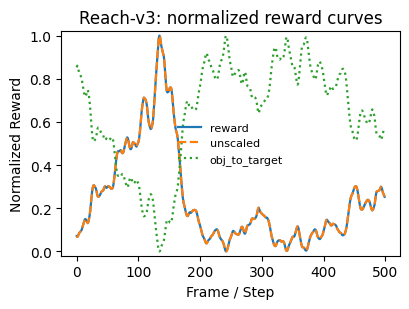

In [24]:
done_step = len(rewards) - 1  # 或者你 break 的 t
curves = {
    "reward": rewards,
    "unscaled": unscaled,
    "obj_to_target": obj_to_target,
}

plot_normalized_rewards(
    curves,
    smooth_window=None,          # 不平滑就 None；想论文感就改成 5/9
    # vlines=[0, done_step],       # 起点+终点 竖直虚线
    title="Reach-v3: normalized reward curves"
)


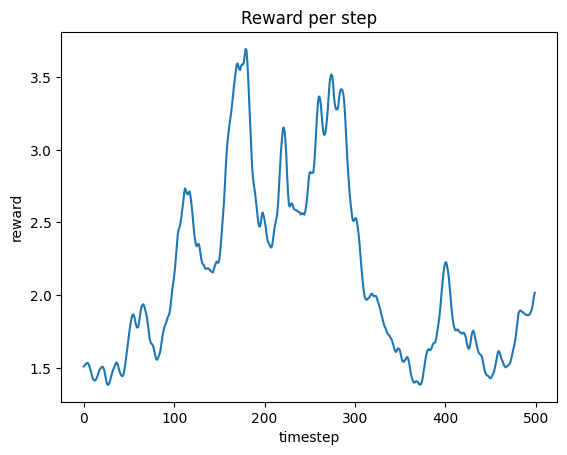

In [47]:
plt.figure()
plt.plot(rewards)          # 默认就是逐点连线，没有平滑
plt.xlabel("timestep")
plt.ylabel("reward")
plt.title("Reward per step")
plt.show()

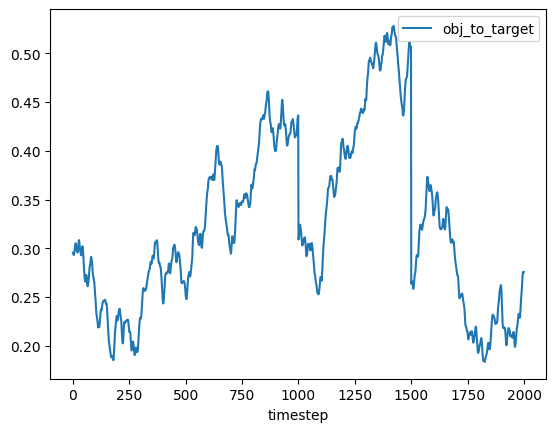

In [45]:
plt.figure()
plt.plot(obj_to_target, label="obj_to_target")
plt.xlabel("timestep")
plt.legend()
plt.show()

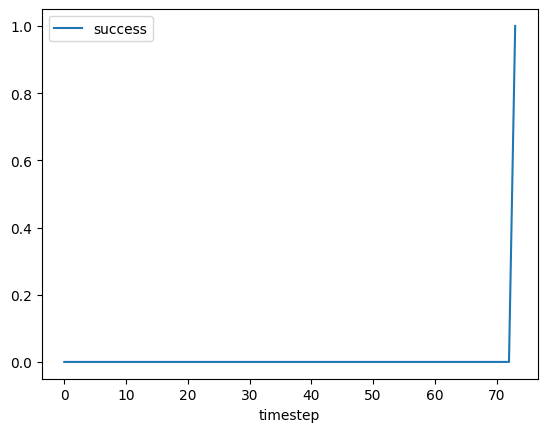

In [13]:
plt.figure()
plt.plot(successes, label="success")
plt.xlabel("timestep")
plt.legend()
plt.show()